# Demonstration of ray actors on algorithm for solving the maximum clique problem


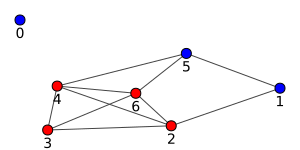

In [103]:
# visualization of a graph with a maximum clique of size 4 (vertices 2, 3, 4, 6)
import igraph
g = igraph.Graph()
g.add_vertices([0, 1, 2, 3, 4, 5, 6])
g.add_edges([(1, 2), (1,5), (2,3), (2,4), (2,6), (3,4), (3,6), (4,5), (4,6), (5,6)])
g.vs["color"] = ["blue", "blue", "red", "red", "red", "blue", "red"]
g.vs["label"] = [f"\n\n {v_i.index}" for v_i in g.vs]
igraph.plot(g, vertex_size=10, bbox = (300, 150), margin = 20, layout = g.layout("kk"))

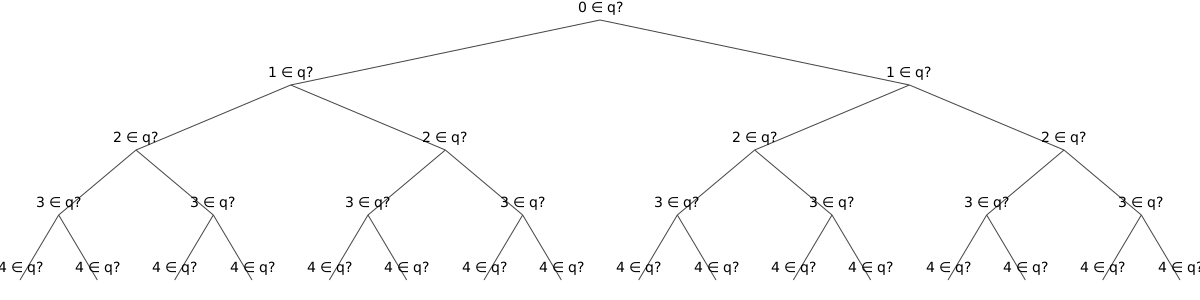

In [104]:
# visualization of the search through the space of possible solutions
import igraph
import numpy as np
from IPython.display import SVG, display, Image
g = igraph.Graph.Tree(31, 2)
g.vs['label'] = [f'{int(np.log2(1+v_i.index))} ∈ q?\n\n' for v_i in g.vs]
# igraph has difficulties rendering to svg/on screen; render to png file enstead, then show the png on screen
igraph.plot(g, 'search_tree.png', vertex_size=0, bbox = (1200, 300), layout = g.layout("tree", root=0))
display(Image(filename='search_tree.png'))

## The maximum clique algorithms

In [ ]:
# import all that the requirements
import numpy as np
import igraph
import math
from colorama import Fore, Style
from time import time
import random

### Create a random graph to work with

In [ ]:
random.seed(1)
graphs=[igraph.Graph.GRG(num_vertices, 0.35) for num_vertices in (20, 100, 200, 300, 400, 500, 600, 700, 800, 900)]
g=graphs[0]
g.vs["label"] = [f"\n\n{v_i.index}" for v_i in g.vs]
igraph.plot(g, vertex_size=10, bbox = (300, 300), margin = 20)

### Sequential maximum clique algorithm
Define the maximum clique algorithm and a helper function for verifying the results

In [ ]:
# function to test whether the given set of vertices is a clique
def checkClique(g, q):
    """
    Verify that q truly is a clique within g.
    """
    v = set(q)
    is_ok = True
    for v_i in v:
        #print(v.intersection(g.neighbors(v_i)))
        is_ok = is_ok and len(v.intersection(g.neighbors(v_i))) >= len(v)-1
    return is_ok

# Test function for calling the algorithm and displaying the relevant stats
numSteps=0
def testAlgorithm(g, alg):
    global numSteps

    t1=time()
    numSteps=0
    q = alg(g, [v.index for v in g.vs])
    t2=time()

    print(f"Graph with {len(g.vs)} vertices;")
    print(f"Clique of size {len(q)}: {q};")
    if isinstance(numSteps, list):
        print(f"{alg.__name__} took {Fore.GREEN}{numSteps}={sum(numSteps)} steps / {t2-t1:.2f} seconds{Style.RESET_ALL};")
    else:
        print(f"{alg.__name__} took {Fore.GREEN}{numSteps} steps / {t2-t1:.2f} seconds{Style.RESET_ALL};")
    if not checkClique(g, q):
        print(f"{Fore.RED}Is the result a clique?{Style.RESET_ALL}")

In [ ]:
# sequential algorithm, straightforward but slow
def maxClique0(g, v, q=[], qmax=[]):
    """
    Algorithm for exhaustive search
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    q ... current clique
    qmax .. max clique found so far
    """
    global numSteps
    numSteps += 1
    if len(v)==0:
        return qmax
    v_1 = v.pop()
    nbh = set(g.neighbors(v_1))
    v_new = nbh.intersection(v)
    q_new = q.copy()
    q_new.append(v_1)
    if len(q_new)>len(qmax):
        qmax = q_new
    # recurse
    qmax = maxClique0(g, v, q, qmax)
    qmax_1 = maxClique0(g, v_new, q_new, qmax)
    # return the largest found clique
    return qmax if len(qmax) > len(qmax_1) else qmax_1

### Improve the sequential algorithm
- dual recursion is changed to a single recursion + iteration

In [ ]:
def maxClique1(g, v, q=[], qmax=[]):
    """
    Algorithm for exhaustive search
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    q ... current clique
    qmax .. max clique found so far
    """
    global numSteps
    numSteps += 1
    while len(v) > 0:
        v_i = v.pop()
        # assumption that v_i can be added to q is used here
        q_new = q.copy()
        q_new.append(v_i)
        # keep only vertices from v that can be added to q_new in v_new (neighbours of v_i)
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        # update the maximum clique
        if len(q_new)>len(qmax):
            qmax = q_new
        # recurse
        qmax = maxClique1(g, v_new, q_new, qmax)
    # return the largest found clique
    return qmax

Test the algorithms

In [ ]:
testAlgorithm(graphs[0], maxClique0)
testAlgorithm(graphs[0], maxClique1)

### Improve the algorithm further
- use the information about the maximum clique so far

In [ ]:
def maxClique2(g, v, q=[], qmax=[]):
    """
    Branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    q ... current clique
    qmax .. max clique found so far
    """
    global numSteps
    numSteps += 1
    while (len(v)+len(q)) > len(qmax):
        v_i = v.pop()
        # the assumption that v_i can be added to q is used here
        q_new = q.copy()
        q_new.append(v_i)
        # keep only vertices from v that can be added to q_new in v_new (neighbours of v_i)
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        # update the maximum clique
        if len(q_new)>len(qmax):
            qmax = q_new
        qmax = maxClique2(g, v_new, q_new, qmax)
    # return the largest found clique
    return qmax

In [ ]:
testAlgorithm(graphs[0], maxClique2)
testAlgorithm(graphs[1], maxClique2)
testAlgorithm(graphs[2], maxClique2)
testAlgorithm(graphs[3], maxClique2)
testAlgorithm(graphs[4], maxClique2)

### The parallel algorithm
 - originates in the iterative sequential algorithm
 - divides the tree on _p_ parts (branches), where _p_ is the number of processes
 - each tree branch is searched in an own process

In [ ]:
import ray

if (not ray.is_initialized()):
    ray.init()

def maxClique3(g, v, numThreads=4):
    """
    main part of the ray-based branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    """
    global numSteps
    futures = []
    while len(v) > 0:
        v_i = v.pop()
        q=[v_i]
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        futures.append(maxClique3_remote.remote(g, v_new, q, q))
        if len(futures) >= numThreads-1:
            futures.append(maxClique3_remote.remote(g, v, [], q))
            break
    # wait for the futures
    results = ray.get(futures)
    numSteps = [r[0] for r in results]
    qmax_val = np.argmax([len(r[1]) for r in results])
    # return the largest found clique
    return results[qmax_val][1]

@ray.remote
def maxClique3_remote(g, v, q=[], qmax=[]):
    global numSteps
    numSteps = 0
    q = maxClique3_recursive(g, v, q, qmax)
    return numSteps, q

def maxClique3_recursive(g, v, q=[], qmax=[]):
    """
    single thread of the branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    q ... current clique
    qmax .. max clique found so far
    """        
    global numSteps
    numSteps += 1
    while (len(v)+len(q)) > len(qmax):
        v_i = v.pop()
        q_new = q.copy()
        q_new.append(v_i)
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        if len(q_new)>len(qmax):
            qmax = q_new
        qmax = maxClique3_recursive(g, v_new, q_new, qmax)
    return qmax

testAlgorithm(graphs[4], maxClique3)

### Second parallel algorithm:
- introduces the 'Actor model' (actor is the universal primitive of concurrent computation)
- divides the tree into branches, their number limited only by the number of vertices
- limits the number of processes (each is an actor that processes a single branch at a time) to _p_


In [ ]:
from ray.util import ActorPool

@ray.remote
class MaxCliqueActor4:
    def __init__(self, g):
        self.g = g

    def maxClique4(self, v, q, qmax):
        self.numSteps = 0
        self.max_len = len(qmax)
        q = self.maxClique4_recursive(v, q, qmax)
        return self.numSteps, q

    def maxClique4_recursive(self, v, q=[], qmax=[]):
        """
        single thread of the branch and bound algorithm
        g ... graph
        v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
        q ... current clique
        qmax .. max clique found so far
        """        
        self.numSteps += 1
        while (len(v)+len(q)) > self.max_len:
            v_i = v.pop()
            q_new = q.copy()
            q_new.append(v_i)
            nbh = set(self.g.neighbors(v_i))
            v_new = nbh.intersection(v)
            if len(q_new)>len(qmax):
                qmax = q_new
                self.max_len = len(qmax)
            qmax = self.maxClique4_recursive(v_new, q_new, qmax)
        return qmax

def maxClique4(g, v, numThreads=4):
    """
    main part (the one that the user should call) of the parallel the branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    numThreads ... number of threads to run on
    """
    futures = []
    q_max = []
    pool = ActorPool([MaxCliqueActor4.remote(g) for i in range(numThreads)])
    numSubmited = 0
    results = []
    while len(v) > len(q_max):
        v_i = v.pop()
        q=[v_i]
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        if numSubmited > numThreads:
            # wait for one result before submitting new branches
            results.append(pool.get_next_unordered())
            numSubmited -= 1
            q_max_r = results[-1][1]
            if (len(q_max_r) > len(q_max)):
                q_max = q_max_r
        pool.submit(lambda a, v: a.maxClique4.remote(*v), [v_new, q, q_max])
        numSubmited += 1
    # wait for the futures
    for i in range(numSubmited):
        try:
            results.append(pool.get_next_unordered())
        except:
            print("submitted more tasks than got it returned")
    global numSteps
    
    numSteps = [r[0] for r in results]
    qmax_val = np.argmax([len(r[1]) for r in results])
    # return the largest found clique
    return results[qmax_val][1]

testAlgorithm(graphs[4], maxClique4)

### A Slight improvement to the parallel algorithm:
- remote function calls are expensive, so perform the clique size check before a call is made

In [ ]:
from ray.util import ActorPool

@ray.remote
class MaxCliqueActor5:
    def __init__(self, g):
        """
        g ... graph
        """
        self.g = g

    def maxClique5(self, v, q, qmax):
        self.numSteps = 0
        self.max_len = len(qmax)
        q = self.maxClique5_recursive(v, q, qmax)
        return self.numSteps, q

    def maxClique5_recursive(self, v, q=[], qmax=[]):
        """
        single thread of the branch and bound algorithm
        v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
        q ... current clique
        qmax .. max clique found so far
        """        
        self.numSteps += 1
        while (len(v)+len(q)) > self.max_len:
            v_i = v.pop()
            q_new = q.copy()
            q_new.append(v_i)
            nbh = set(self.g.neighbors(v_i))
            v_new = nbh.intersection(v)
            if len(q_new)>len(qmax):
                qmax = q_new
                self.max_len = len(qmax)
            qmax = self.maxClique5_recursive(v_new, q_new, qmax)
        return qmax

def maxClique5(g, v, numThreads=4):
    """
    main part (the one that the user should call) of the parallel the branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    numThreads ... number of threads to run on
    """
    futures = []
    q_max = []
    pool = ActorPool([MaxCliqueActor5.remote(g) for i in range(numThreads)])
    numSubmited = 0
    results = []
    while len(v) > len(q_max):
        v_i = v.pop()
        q=[v_i]
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        if (len(v_new) + len(q)) > len(q_max):
            if numSubmited > numThreads:
                numSubmited -= 1
                results.append(pool.get_next_unordered())
                q_max_r = results[-1][1]
                if (len(q_max_r) > len(q_max)):
                    q_max = q_max_r
            pool.submit(lambda a, v: a.maxClique5.remote(*v), [v_new, q, q_max])
            numSubmited += 1
    # wait for the futures
    for i in range(numSubmited):
        try:
            results.append(pool.get_next_unordered())
        except:
            print("submitted 1 more task than got it returned")
    global numSteps
    numSteps = [r[0] for r in results]
    qmax_val = np.argmax([len(r[1]) for r in results])
    # return the largest found clique
    return results[qmax_val][1]

testAlgorithm(graphs[4], maxClique5)

### The last parallel algorithm:
- added a shared clique size between all the processes

In [ ]:
from ray.util import ActorPool

@ray.remote
class MaxCliqueActor6:
    def __init__(self, g, q_max_len):
        self.g = g
        self.q_max_len = q_max_len
        self.q_max_len.flags.writeable = True

    def maxClique6(self, v, q):
        self.numSteps = 0
        q = self.maxClique6_recursive(v, q)
        return self.numSteps, q

    def maxClique6_recursive(self, v, q=[]):
        """
        single thread of the branch and bound algorithm
        v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
        q ... current clique
        """        
        self.numSteps += 1
        qmax=q
        while (len(v)+len(q)) > self.q_max_len[0]:
            v_i = v.pop()
            q_new = q.copy()
            q_new.append(v_i)
            nbh = set(self.g.neighbors(v_i))
            v_new = nbh.intersection(v)
            if len(q_new)>self.q_max_len[0]:
                self.q_max_len[0]=len(q_new)
                qmax = q_new
            qmax1 = self.maxClique6_recursive(v_new, q_new)
            if len(qmax1)>len(qmax):
                qmax=qmax1
        return qmax

def maxClique6(g, v, numThreads=4):
    """
    main part (the one that the user should call) of the parallel the branch and bound algorithm
    g ... graph
    v ... vertices to use, assume any can be added to q and q will remain a clique (this is trivially so when q is empty); thus all elements in v must be neighbours to all elements in q
    numThreads ... number of threads to run on
    """
    known_max_len = np.ones(1)
    known_max_len_id = ray.put(known_max_len)
    futures = []
    q_max = []
    pool = ActorPool([MaxCliqueActor6.remote(g, known_max_len_id) for i in range(numThreads)])
    numSubmited = 0
    results = []
    local_len = known_max_len[0]
    while len(v) > local_len:
        v_i = v.pop()
        q=[v_i]
        nbh = set(g.neighbors(v_i))
        v_new = nbh.intersection(v)
        if (len(v_new) + len(q)) > local_len:
            if numSubmited > numThreads:
                numSubmited -= 1
                results.append(pool.get_next_unordered())
            pool.submit(lambda a, v: a.maxClique6.remote(*v), [v_new, q])
            local_len = ray.get(known_max_len_id)[0]
            numSubmited += 1
    # wait for the futures
    for i in range(numSubmited):
        try:
            results.append(pool.get_next_unordered())
        except:
            print("submitted 1 more task than got it returned")
    global numSteps
    numSteps = [r[0] for r in results]
    qmax_val = np.argmax([len(r[1]) for r in results])
    # return the largest found clique
    return results[qmax_val][1]

testAlgorithm(graphs[4], maxClique6)